<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%207/Lecture_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Virtual Summer School: Machine Learning in Electron Microscopy
#Linear methods and dimensionality reduction for video data

Lecture 7, June 27

- Notebook by Mani Valleti, UT Knoxville
- Modified by Sergei V. Kalinin, UT Knoxville

In [1]:
!pip install -q atomai  # We will use this

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import atomai as aoi

from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 45.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 55.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [2]:
!pip install -q atomai

In [3]:
!gdown 1bcLU6PtLWCnRrDd24yo5vuXMiCoEEKzW
!gdown 1JtpMNTGUrdXEiqjm00igYNhlrSxzNnJP

!unzip -q Img_stack.zip

Downloading...
From: https://drive.google.com/uc?id=1bcLU6PtLWCnRrDd24yo5vuXMiCoEEKzW
To: /content/Temp_profile.dat
100% 6.59k/6.59k [00:00<00:00, 27.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JtpMNTGUrdXEiqjm00igYNhlrSxzNnJP
To: /content/Img_stack.zip
100% 588M/588M [00:13<00:00, 43.4MB/s]


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde

import seaborn as sns
from tqdm import tqdm
from atomai import utils

In [5]:
datfile = "Temp_profile.dat"
datadir = "Image_stack"

sorted_filelist = sorted(os.listdir(datadir),
                         key=lambda fname: int(fname.split('.')[0][-4:]))
images = []
for i, fname in enumerate(sorted_filelist):
    print("\rImage {}/{}".format(i+1, len(sorted_filelist)), end="")
    if fname.endswith('.tif'):
        images.append(cv2.imread(os.path.join(datadir, fname), -1))
images = np.array(images)  # Assumes that all images have the same size
print("\n", images.shape)

images = utils.cv_resize_stack(images, (512, 512))
images = images/images.max()

"""Load dat file"""
dat = np.loadtxt(datfile)
print(dat.shape)
plt.plot(dat[:,0],dat[:,1])
plt.xlabel('Time')
plt.ylabel('Temperature')

Image 521/521
 (521, 753, 753)
(521, 2)


Text(0, 0.5, 'Temperature')

In [6]:
"""Plot images at different times (temperature)"""

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))

inds = [0, 30, 60, 120, 325, -1]

for ind, ax0 in zip(inds, ax.flatten()):
    ax0.imshow(images[ind], cmap = 'gray')
    ax0.set_title('T: ' + str(dat[ind, 1]) + 'C')
    ax0.axis('off')


In [7]:
#Creating subimage statck using AtomAI library

np.random.seed(123)
images_input = images
num_of_subimgs = 500
window_size = 48
imstack, com_all, frames_all = utils.extract_random_subimages(images_input, window_size, num_images=num_of_subimgs) # num_images is number of images *per frame*
imstack = imstack[..., 0] # disregard channel dimension for grayscale data

d1, _, _ = images.shape
info_arr = np.zeros(([d1*num_of_subimgs ,3]))

for k in range(d1):
    for i in range(num_of_subimgs):
        info_arr[k*num_of_subimgs + i, 0], info_arr[k*num_of_subimgs + i, 1], info_arr[k*num_of_subimgs + i, 2] = k, dat[k,0], dat[k,1]

In [8]:
# !!!! DO NOT RUN THIS CELL
# It eats up all your RAM and takes all session to run. The results are downloaded in the next cell



# GMM Analysis
# from sklearn.mixture import GaussianMixture

# window_size = imstack.shape[-1]
# z = imstack.reshape(-1, window_size*window_size)
# nc = 8 #Try 4, 8, 16, 32
# gmm = GaussianMixture(n_components=nc)
# gmm_predict = gmm.fit_predict(z)

# np.save('class_index_48.npy', gmm_predict)

# means_min, means_max = np.min(gmm.means_, axis = 1).reshape([-1,1]), np.max(gmm.means_, axis = 1).reshape([-1,1])
# means = (gmm.means_ - means_min)/(means_max - means_min)

# np.save('gmm_means.npy', means)

In [9]:
# Downloading and reading the results of GMM analysis

!gdown 1p80gh4MaOZ8TZqwszP1lfdGZ5mAwxi0n
!gdown 14qRidgHnyi5Jeq8Cm8dC5cPOoxHQsWRY

class_index = np.load('class_index_48.npy')
gmm_means = np.load('gmm_means.npy')

Downloading...
From: https://drive.google.com/uc?id=1p80gh4MaOZ8TZqwszP1lfdGZ5mAwxi0n
To: /content/class_index_48.npy
100% 2.08M/2.08M [00:00<00:00, 208MB/s]
Downloading...
From: https://drive.google.com/uc?id=14qRidgHnyi5Jeq8Cm8dC5cPOoxHQsWRY
To: /content/gmm_means.npy
100% 148k/148k [00:00<00:00, 117MB/s]


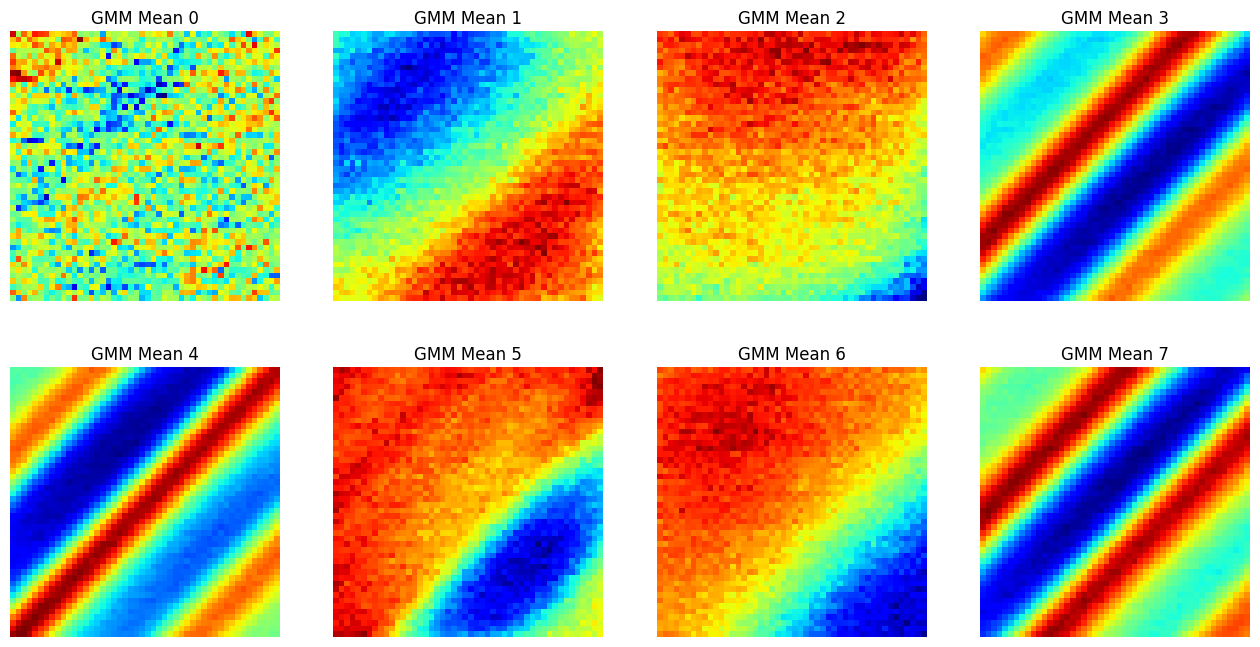

In [10]:
nc = 8
rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(gmm_means[i,:].reshape(window_size, window_size), cmap = 'jet') #,
    ax2.set_title('GMM Mean ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')

In [11]:
# Here we create a pandas dataframe that contains the descriptors of the data
# Each row represents a sub-image and the columns are
# Frame number, time, temperature, and GMM class index of the sub-image

import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

dataGM = np.hstack((info_arr, np.expand_dims(class_index, axis = 1)))
dataGM = pd.DataFrame(dataGM, columns=['Frame', 'Time', 'Temperature', 'GMM Index'])

# Take a look at the data frame created
dataGM.head()

Frame  Time  Temperature  GMM Index
0    0.0   0.0         23.0        6.0
1    0.0   0.0         23.0        6.0
2    0.0   0.0         23.0        1.0
3    0.0   0.0         23.0        1.0
4    0.0   0.0         23.0        6.0

In [12]:
# KDE of GMM class index

#inputs
to_analyze = ['GMM Index']
frame_col = ['Frame']


frames = np.unique(dataGM[frame_col])  #Number of different time(frame) steps
# num_of_points = len(frames)  # can change the number of points here, for now we are making square images
num_of_points = 480
points = np.zeros([len(to_analyze),num_of_points])  #Values' grid
pdf = np.zeros([len(to_analyze), len(frames), num_of_points])   #PDF array

limits = np.zeros(len(to_analyze))
for i, col in enumerate(to_analyze):
    # Let's get the limits here
    a = np.maximum(np.abs(np.amax(dataGM[col])), np.abs(np.amin(dataGM[col])))
    # limits[i] = 2.0*a #np.ceil(2.0*a)
    points[i] = np.linspace(-1,9, num_of_points)
    for j, frame in enumerate(frames):
        data_cons = dataGM[np.array(dataGM[frame_col] == frame)]
        kernel = gaussian_kde(data_cons[col], bw_method= 0.1)
        pdf[i, j] = kernel(points[i])

#output will be pdf of shape [a,b,c], where a corresponds to different columns analyzed
# b corresponds to the number of distinct time steps and
# c corresponds to the number of points time axis is divided into

# limits for each column are saved in 'limits' array in the same order.

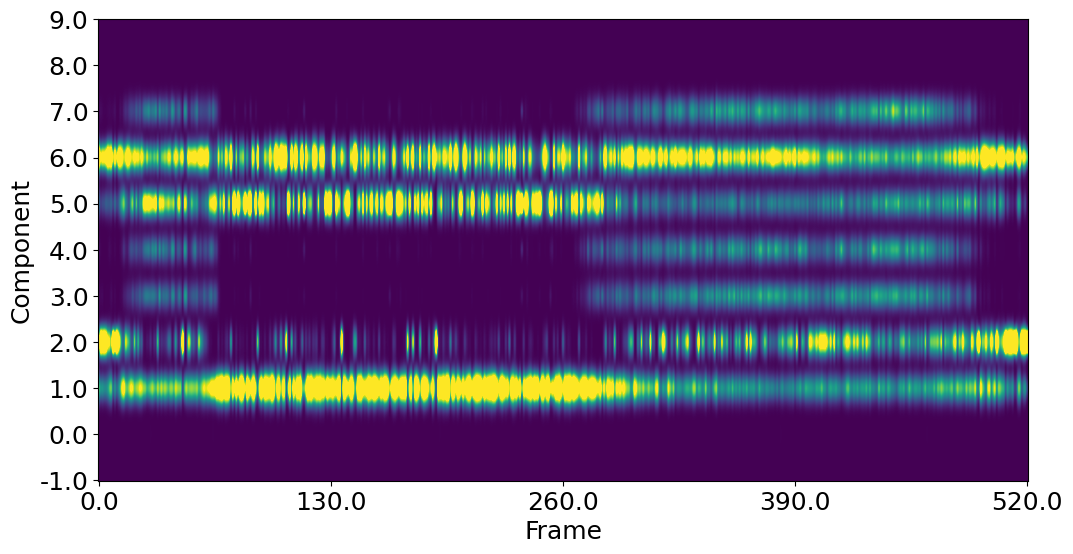

In [13]:
"""Plotting the Kernel Densities (PDFS)"""
fig, ax = plt.subplots(nrows = 1, ncols = len(to_analyze), figsize = (12,6))
for i in range(len(to_analyze)):
    ax.imshow(pdf[i].T, aspect = 'auto', vmin = 0, vmax = 0.5, interpolation = 'gaussian', filterrad = 0.5)
    ax.invert_yaxis()
    ax.set_xticks((np.round(np.linspace(np.amin(frames),np.amax(frames),5))))
    ax.set_yticks((np.linspace(0,num_of_points-1,11)))

    ax.set_yticklabels(np.round(np.linspace(-1,9,11), decimals = 2), fontsize = 18)
    ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    #plt.xticks(fontsize = 18)
    ax.set_xlabel('Frame', fontsize = 18)
    ax.set_ylabel('Component', fontsize = 18)

-- Each column in the above plot now acts as a descriptor of a frame in the dataset
-- Intensity of this line corresponds to the number of sub-images that belong to a particular GMM class
-- For example, first few frames (low-temperature) have a lot of sub-images belonging to classes 2 and 6 and a few from classes 1 and 5


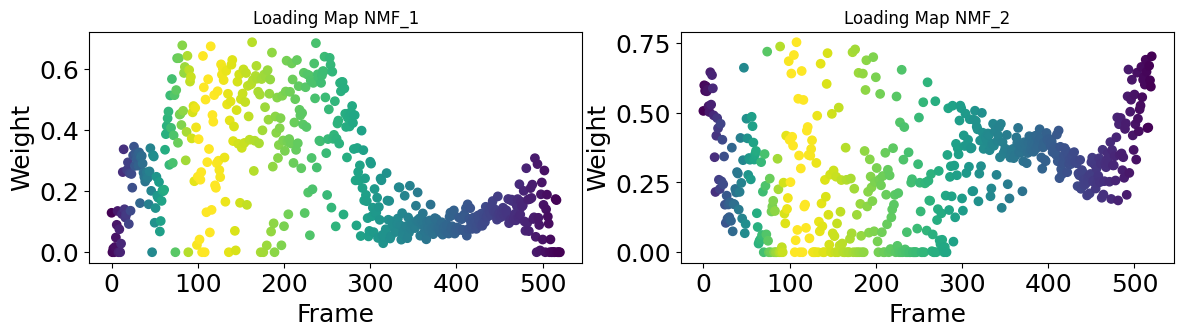

In [14]:
# With these vectors as the descriptors to each frame in the dataset,
# Let's apply NMF on the dataset
"""NMF"""
from sklearn.decomposition import NMF
n_comp = 2
fig, ax = plt.subplots(nrows = len(pdf), ncols = n_comp, figsize = (14,3))
components = np.zeros([len(to_analyze), n_comp, num_of_points])
i = 0

decomp = NMF(n_components = n_comp)
nmf = decomp.fit_transform(pdf[i])
components[i] = decomp.components_

# plotting the loading maps in time and coloring them using Temperature
for j in range(n_comp):
  ax[j].scatter(np.arange(521),nmf[:,j], c = dat[:,1]) #frames
  ax[j].set_xlabel('Frame', fontsize = 18)
  ax[j].set_ylabel('Weight', fontsize = 18)
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
  ax[j].tick_params(axis='x', labelsize= 18)
  ax[j].tick_params(axis='y', labelsize= 18)
  #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
  ax[j].set_title('Loading Map ' + 'NMF_' +str(j+1))

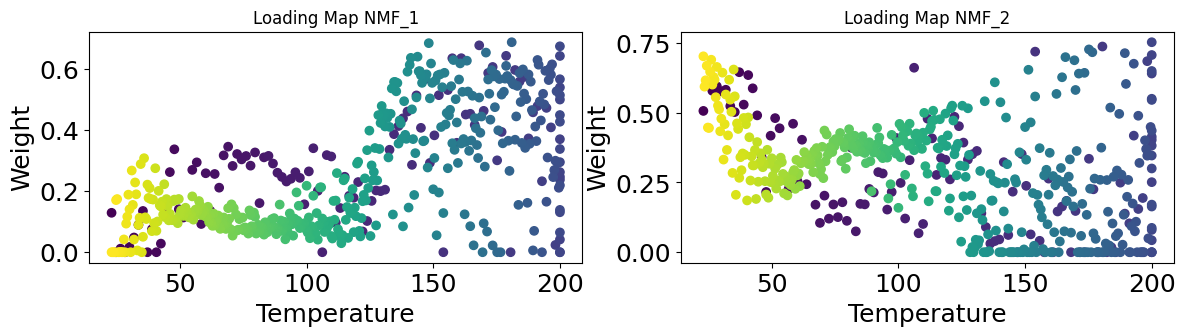

In [15]:
# plotting the loading maps as a function of temperature and coloring them using Frame

fig, ax = plt.subplots(nrows = len(pdf), ncols = n_comp, figsize = (14,3))
for j in range(n_comp):
  ax[j].scatter(dat[:,1],nmf[:,j], c = dat[:,0]) #frames
  ax[j].set_xlabel('Temperature', fontsize = 18)
  ax[j].set_ylabel('Weight', fontsize = 18)
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
  ax[j].tick_params(axis='x', labelsize= 18)
  ax[j].tick_params(axis='y', labelsize= 18)
  #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
  ax[j].set_title('Loading Map ' + 'NMF_' +str(j+1))

<ipython-input-16-673353b39c6a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j].set_yticklabels(np.round(ax[j].get_yticks(), decimals=1), fontsize = 18)


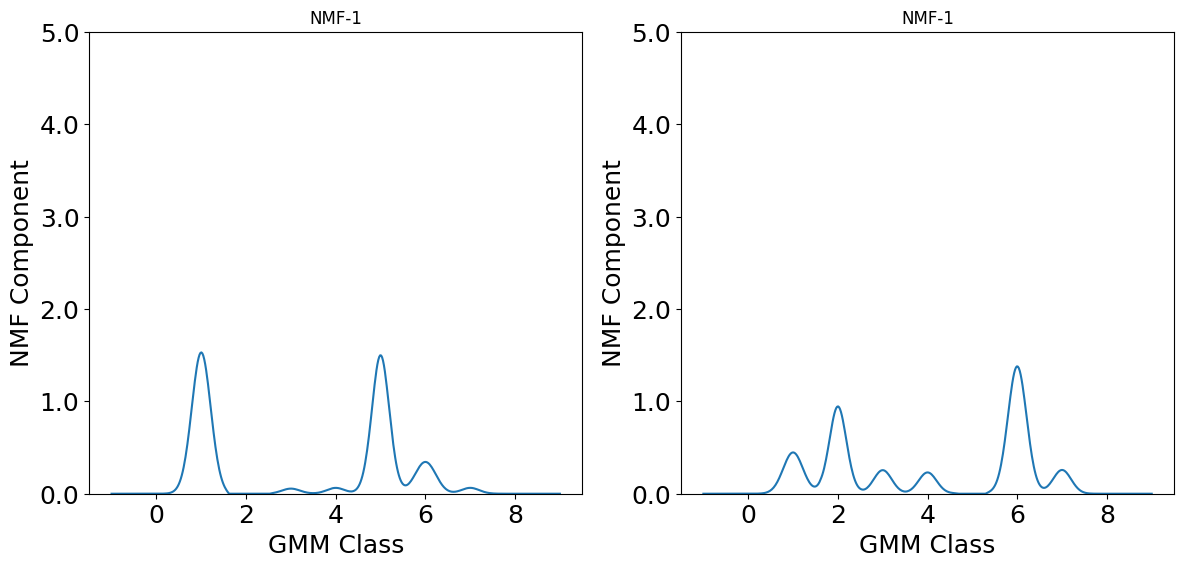

In [16]:
# Visulazing the components of the NMF (Equivalent to principal axes in PCA)

fig, ax = plt.subplots(nrows = len(to_analyze), ncols = n_comp, figsize = (14,6))
i = 0
for j in range(n_comp):
  ax[j].plot(points[i], components[i,j])
  ax[j].set_xlabel('GMM Class', fontsize = 18)
  ax[j].set_ylabel('NMF Component', fontsize = 18)
  ax[j].set_ylim((0,5))
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks(), fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks())
  ax[j].set_yticklabels(np.round(ax[j].get_yticks(), decimals=1), fontsize = 18)
  ax[j].tick_params(axis='x', labelsize= 18)
  ax[j].set_title('NMF-'+str(i+1))

If you have more than 15 minutes left in the session, then proceed to the next section and you really need the High RAM runtime for this or the session would crash

In [17]:
#@title  Class for analysis and Function for KDE
class Tileli_analysis:

  def __init__(self, images_input, num_subimgs = 100, window_size = 24,
               transformation = 'fft', theta_points = 30, decomposition = 'nmf', n_comp = 3):

    self.images_input = images_input
    self.num_subimgs = num_subimgs
    self.window_size = window_size
    self.transformation = transformation
    self.decomposition = decomposition
    self.n_comp = n_comp
    self.img_dim = window_size

    if self.transformation == 'radon':
      self.theta_points = theta_points
      self.img_dim = theta_points

    self.img_data = pd.DataFrame()


  def encode(self):
    self.imstack, com_all, frames_all = utils.extract_random_subimages(self.images_input, self.window_size, num_images = self.num_subimgs)
    self.imstack = self.imstack[..., 0] # disregard channel dimension for grayscale data
    frame_num = np.arange(len(self.images_input))
    self.img_data['Frame'] = frames_all
    self.img_data['time'] = np.nan
    self.img_data['temperature'] = np.nan
    self.img_data['com_1'] = com_all[:,0]
    self.img_data['com_2'] = com_all[:,1]

    for i in range((self.images_input).shape[0]):
      self.img_data['time'][self.num_subimgs*i:self.num_subimgs*(i+1)] = np.ones(self.num_subimgs)*dat[int(frame_num[i]),0]
      self.img_data['temperature'][self.num_subimgs*i:self.num_subimgs*(i+1)] = np.ones(self.num_subimgs)*dat[int(frame_num[i]),1]


    print('Applying tansformations\n')

    # Transformation block
    if self.transformation == 'fft':
      transformed_mat = self.do_fft(self.imstack)

    elif self.transformation == 'radon':
      transformed_mat = self.do_radon(self.imstack, self.theta_points)

    elif self.transformation == 'identity':
      transformed_mat = self.do_identity(self.imstack)

    else:
      raise NotImplementedError("Choose between 'fft', 'radon', and 'identity' transformations")

    # Decomposition block
    print('Applying linear unmixing techniques')
    if self.decomposition == 'pca':
      self.weights, self.pca_exp_var_ratio = self.do_pca(transformed_mat, nc = self.n_comp)

    elif self.decomposition == 'nmf':
      self.weights, self.nmf_error = self.do_nmf(transformed_mat, nc = self.n_comp)

    else:
      raise NotImplementedError("Choose between 'pca', 'nmf' for decomposition")


    return 'Encoding Done'

  def decode(self, frame_num = 25, batch_update = False, num_of_frames = 2, stride = 4):

    self.batch_update = batch_update
    self.stride = stride

    if self.batch_update:
      self.num_of_frames = num_of_frames
      self.frame_num = np.linspace(0, (self.images_input).shape[0]-1, self.num_of_frames).astype(int)
      self.images_selected = images[self.frame_num]


    elif not(self.batch_update):
      self.num_of_frames = 1
      self.frame_num = frame_num
      self.images_selected = self.images_input[self.frame_num]

    slided_imgs, num = self.make_sliding_subimgs()


    print('Applying tansformations\n')

    # Transformation block
    if self.transformation == 'fft':
      trans_slided_mat = self.do_fft(slided_imgs)

    elif self.transformation == 'radon':
      trans_slided_mat = self.do_radon(slided_imgs, self.theta_points)

    elif self.transformation == 'identity':
      trans_slided_mat = self.do_identity(slided_imgs)

    decoded = np.matmul(trans_slided_mat, np.transpose(self.weights))

    self.decoded = decoded.reshape([self.num_of_frames, num, num, self.n_comp])


    return 'Decoding Done'



  def do_fft(self, imgs):
    img_size_1 = np.shape(imgs)[1]
    img_size_2 = np.shape(imgs)[2]
    fft = np.zeros([len(imgs), img_size_1, img_size_2])
    from scipy import fftpack
    # Does fast fourier transform and shifts origin to center
    for i in tqdm(range(len(imgs))):
      img_fft = fftpack.fftshift(fftpack.fft2(imgs[i]))
      img_fft_amp = np.sqrt(np.abs(img_fft))
      fft[i] = (img_fft_amp - np.amin(img_fft_amp))/np.ptp(img_fft_amp)

    if np.isnan(np.sum(fft)):
      raise NotImplementedError("fft ka problem")

    feature_mat_fft = np.zeros([len(imgs), img_size_1*img_size_2])
    for i in range(len(imgs)):
      feature_mat_fft[i] = np.ndarray.flatten(fft[i])

    if np.isnan(np.sum(feature_mat_fft)):
      raise NotImplementedError("I've no idea what's happening")

    return feature_mat_fft



  def do_radon(self, imgs, theta_points = 30):
    # See if you can make this faster
    from skimage.transform import radon
    img_size_1 = np.shape(imgs)[1]
    img_size_2 = np.shape(imgs)[2]

    radon_tran = np.zeros([len(imgs), img_size_1, theta_points])
    thetas = np.linspace(0., 180., theta_points)
    for i in tqdm(range(len(imgs))):
      sinogram = radon(imgs[i], theta=thetas, circle=True)
      # print(np.shape(sinogram))
      radon_tran[i] = (sinogram - np.amin(sinogram))/np.ptp(sinogram)
      # radon_tran[i] = sinogram

    if np.isnan(np.sum(radon_tran)):
      raise NotImplementedError("radon ka problem")

    feature_mat_radon = np.zeros([len(imgs), img_size_1*theta_points])
    for i in range(len(imgs)):
      feature_mat_radon[i] = np.ndarray.flatten(radon_tran[i])

    return feature_mat_radon


  def do_identity(self, imgs):
    img_size_0 = np.shape(imgs)[1]
    img_size_1 = np.shape(imgs)[2]

    feature_mat = np.zeros([len(imgs), img_size_0*img_size_1])
    for i in tqdm(range(len(imgs))):
      feature_mat[i] = np.ndarray.flatten(imgs[i])

    return feature_mat

  def do_pca(self, feat_mat, nc):
    comp_list = []
    for i in range(nc):
      comp_list.append('comp_'+str(i+1))      #prepearing column names for components
      self.img_data['comp_'+str(i+1)] = np.nan     #Initiating new columns for the data frame


    from sklearn.decomposition import PCA

    pca = PCA(n_components=nc)

    pca_load = pca.fit_transform(feat_mat)
    pca_weights = pca.components_
    pca_exp_var_ratio = pca.explained_variance_ratio_

    for j, comp in enumerate(comp_list):
      self.img_data[comp] = pca_load[:,j]   #updating the data frame with loading maps

    return pca_weights, pca_exp_var_ratio


  def do_nmf(self, feat_mat, nc):
    comp_list = []
    for i in range(nc):
      comp_list.append('comp_'+str(i+1))      #prepearing column names for components
      self.img_data['comp_'+str(i+1)] = np.nan     #Initiating new columns for the data frame


    from sklearn.decomposition import NMF

    nmf = NMF(n_components=nc)

    nmf_load = nmf.fit_transform(feat_mat)
    nmf_weights = nmf.components_
    nmf_error = nmf.reconstruction_err_

    for j, comp in enumerate(comp_list):
      self.img_data[comp] = nmf_load[:,j]   #updating the data frame with loading maps

    return nmf_weights, nmf_error

  def MakeWindow(self, imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    img_cut = imgsrc[int(xpos-self.window_size/2):int(xpos+self.window_size/2),
                    int(ypos-self.window_size/2):int(ypos+self.window_size/2)]
    return img_cut

  def make_sliding_subimgs(self):
    image_size = self.images_selected.shape[1]

    num_sliding_sub_imgs = len(np.arange(int(self.window_size/2), int(image_size - self.window_size/2),self.stride))
    sliding_sub_imgs = np.zeros([self.num_of_frames * num_sliding_sub_imgs*num_sliding_sub_imgs, self.window_size,self.window_size])

    a = 0  #counter
    for k in range(self.num_of_frames):
      for i in range(int(self.window_size/2), int(image_size - self.window_size/2),self.stride):
        for j in range(int(self.window_size/2), int(image_size - self.window_size/2), self.stride):

          sliding_sub_imgs[a]  = (self.MakeWindow(self.images_selected[k], i,j))
          a += 1

    return sliding_sub_imgs, num_sliding_sub_imgs


def do_kde(data, cols_to_analyze, frame_col, num_of_points = 150):

    frames = np.unique(data[frame_col])  #Number of different time(frame) steps

    points = np.zeros([len(cols_to_analyze),num_of_points])  #Values' grid
    pdf = np.zeros([len(cols_to_analyze), len(frames), num_of_points])   #PDF array

    limits = np.zeros(len(cols_to_analyze))
    limits_l = np.zeros(len(cols_to_analyze))
    limits_t = np.zeros(len(cols_to_analyze))

    for i, col in enumerate(cols_to_analyze):

        # Let's get the limits here
        # a = np.maximum(np.abs(np.amax(data[col])), np.abs(np.amin(data[col])))
        # limits[i] = np.ceil(1.5*a)
        # points[i] = np.linspace(-limits[i],limits[i], num_of_points)

        limits_l[i] = np.amin(data[col])-0.5
        limits_t[i] = np.amax(data[col])
        points[i] = np.linspace(limits_l[i],limits_t[i], num_of_points)


        for j, frame in enumerate(frames):
            data_cons = data[np.array(data[frame_col] == frame)]
            kernel = gaussian_kde(data_cons[col], bw_method= 0.1)
            pdf[i, j] = kernel(points[i])
    return pdf, num_of_points, limits_l, limits_t, frames, points

Encoding takes about 10-12 minutes

In [18]:
"""Take the images of the stack (521,512,512),
obtain 'num_subimgs' per frame using Maxim's funciton (521*num_subimgs, window_size, window_size)
Do prescribed 'transformation on the whole matrix (521*num_subimgs, window_size*window_size)
Do prescribed linear unmixing technique on the matrix
save the weights for future use
Do KDE analysis on the data frame like we have done on the GMM class index"""

#theta_points is only used when transformation is radon. It is the number of points theta scale is divided into
analysis = Tileli_analysis(images_input = images, num_subimgs = 500, window_size = 24,
                           transformation = 'fft', theta_points = 45,  # transformation can be radon, fft, identity (radon works best)
                           decomposition = 'nmf',   # Decomposition can be nmf, pca, gmm (decoding with gmm is not implemented)
                           n_comp = 4)

analysis.encode()

#radon pca

Applying tansformations



100%|██████████| 260500/260500 [00:30<00:00, 8522.27it/s]


Applying linear unmixing techniques


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


'Encoding Done'

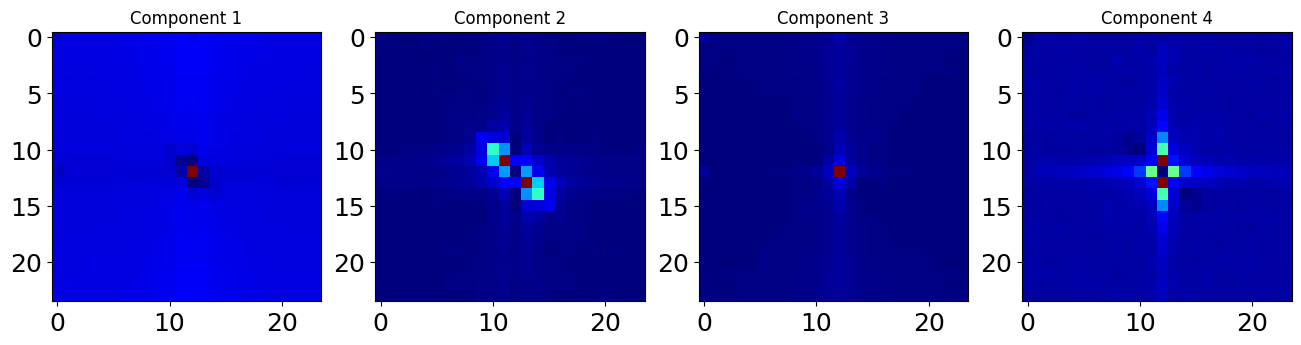

In [19]:
"""Plotting PCA Components (This is similar to the GMM means plots above)"""
rows,cols = 2,4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(4):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(analysis.weights[i].reshape(24, analysis.img_dim), cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)


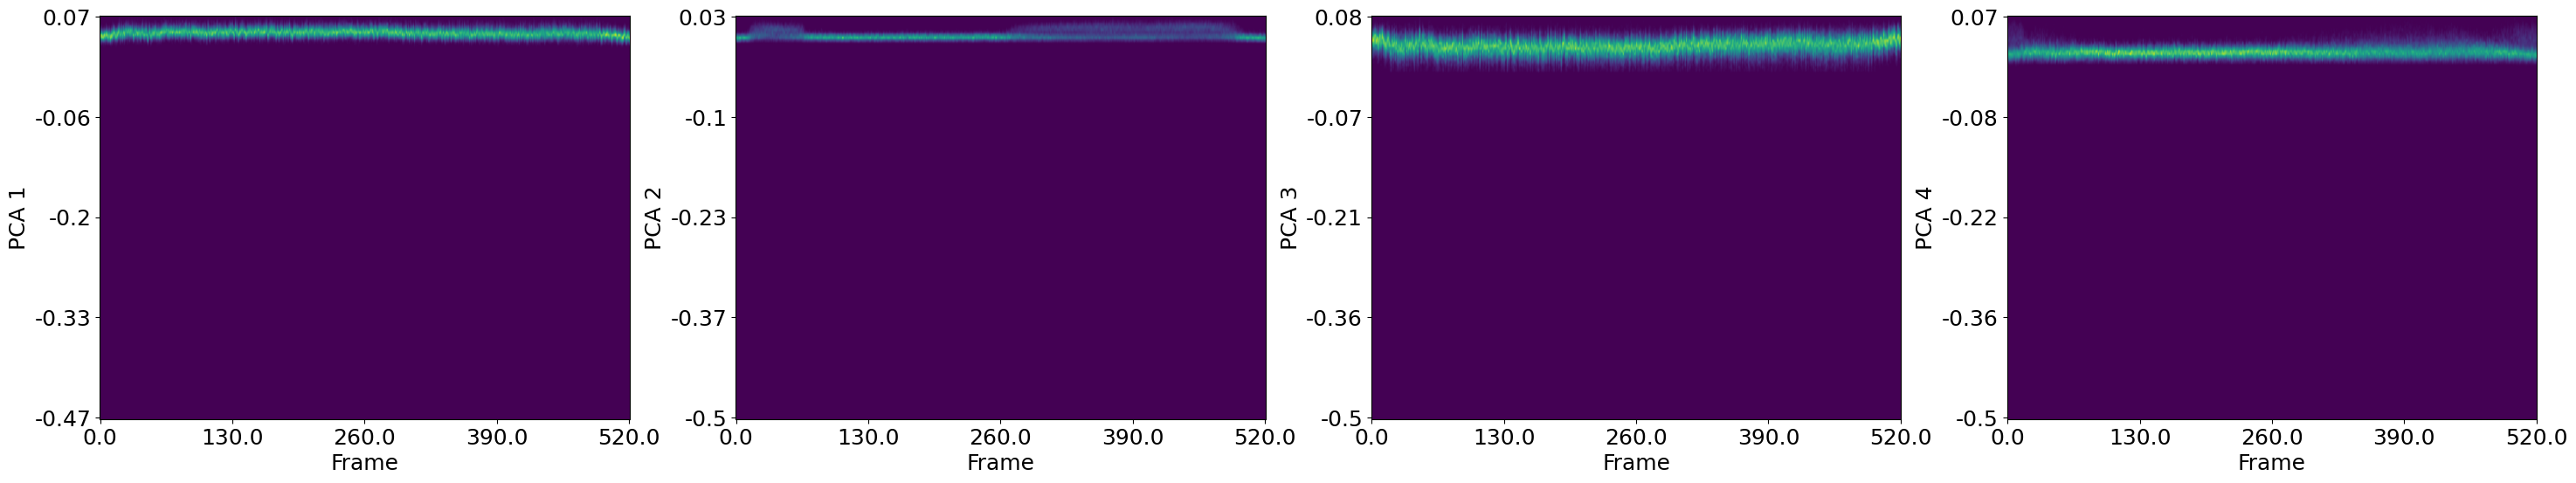

In [20]:
# Kernel Density Estimation of the PCA components (Similar to the KDE plot with GMM )

to_analyze = ['comp_1', 'comp_2', 'comp_3', 'comp_4']
frame_col = ['Frame']

pdf, num_of_points, limits_l, limits_t, frames, points  = do_kde(analysis.img_data, cols_to_analyze=to_analyze, frame_col = frame_col)

"""Plotting the PDFS"""
fig, ax = plt.subplots(nrows = 1, ncols = len(to_analyze), figsize = (36,6))
for i in range(len(to_analyze)):
  ax[i].imshow(pdf[i].T, aspect = 'auto', interpolation = 'gaussian', filterrad = 0.5)
  ax[i].invert_yaxis()

  ax[i].set_yticks((np.linspace(0,num_of_points-1,5)))
  ax[i].set_yticklabels(np.round(np.linspace(limits_l[i],limits_t[i],5), decimals = 2), fontsize = 18)

  ax[i].set_xticks((np.round(np.linspace(np.amin(frames),np.amax(frames),5))))
  ax[i].set_xticklabels(ax[i].get_xticks(), fontsize = 18)

  ax[i].set_xlabel('Frame', fontsize = 18)

  ax[0].set_ylabel('PCA 1', fontsize = 18)
  ax[1].set_ylabel('PCA 2', fontsize = 18)
  ax[2].set_ylabel('PCA 3', fontsize = 18)
  ax[3].set_ylabel('PCA 4', fontsize = 18)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


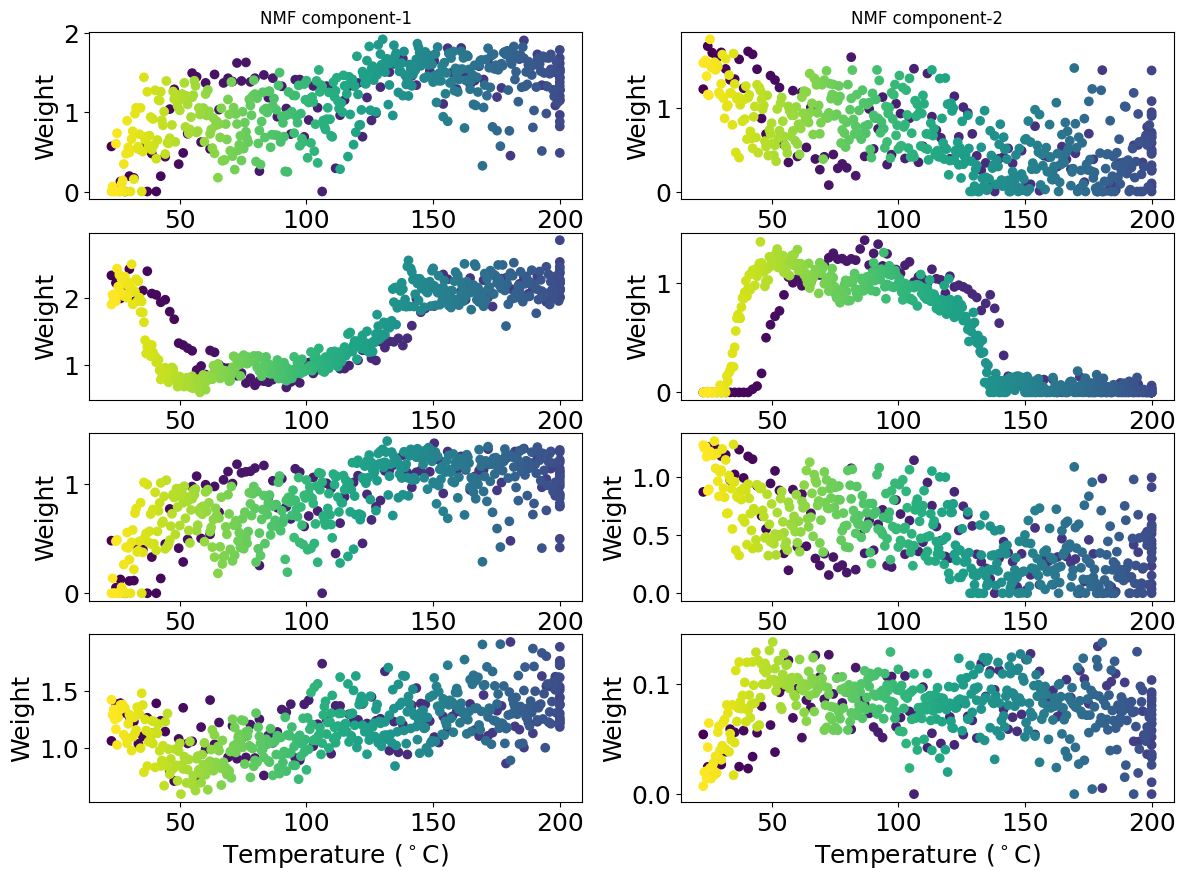

In [21]:
"""
NMF on KDE
Here we decompose KDE of each PAC component into 2 NMF components

"""

from sklearn.decomposition import NMF
n_comp = 2
fig, ax = plt.subplots(len(pdf), ncols = n_comp, figsize = (14,10))
components = np.zeros([len(to_analyze), n_comp, num_of_points])
for i in range(len(pdf)):
  decomp = NMF(n_components = n_comp)
  nmf = decomp.fit_transform(pdf[i])
  components[i] = decomp.components_
  for j in range(n_comp):
    ax[i,j].scatter(dat[:,1],nmf[:,j], c = dat[:,0]) #frames
    #ax[i,j].plot(dat[:,1],nmf[:,j]) #frames
    ax[i,j].set_xlabel('Temperature ($^\circ$C)', fontsize = 18)
    ax[i,j].set_ylabel('Weight', fontsize = 18)
    #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
    #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
    ax[i,j].tick_params(axis='x', labelsize= 18)
    ax[i,j].tick_params(axis='y', labelsize= 18)
    #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
    if i == 0:
        ax[i,j].set_title('NMF component-'+str(j+1))

# Rows correspond to the PCA components on the KDE
# The columns represent NMF components applied to PCA =D
# Color represents the frame number

<ipython-input-22-3a193f81fb6e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)


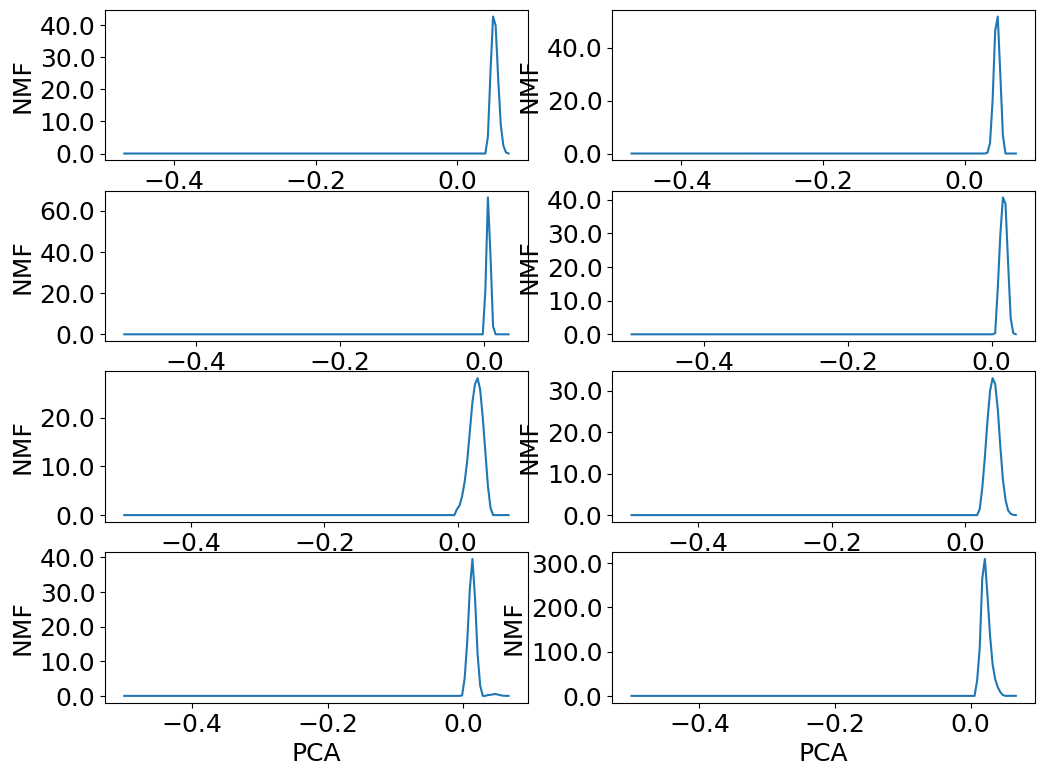

In [22]:
"""Loading Maps"""
fig, ax = plt.subplots(nrows = len(to_analyze), ncols = n_comp, figsize = (12,9))
for i in range(len(components)):
  for j in range(n_comp):
    ax[i,j].plot(points[i], components[i,j])
    ax[i,j].set_xlabel('PCA', fontsize = 18)
    ax[i,j].set_ylabel('NMF', fontsize = 18)
    #ax[i,j].set_ylim((0,3.6))
    #ax[i,j].set_xticklabels(ax[i,j].get_xticks(), fontsize = 18)
    #ax[i,j].set_xticks(ax[i,j].get_xticks())
    ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
    ax[i,j].tick_params(axis='x', labelsize= 18)
    # ax[i,j].set_title('component-'+str(i+1))

In [23]:
# Decoding
analysis.decode(batch_update=True, num_of_frames = 4, stride = 4)
decoded = analysis.decoded

Applying tansformations



100%|██████████| 59536/59536 [00:06<00:00, 8773.09it/s]


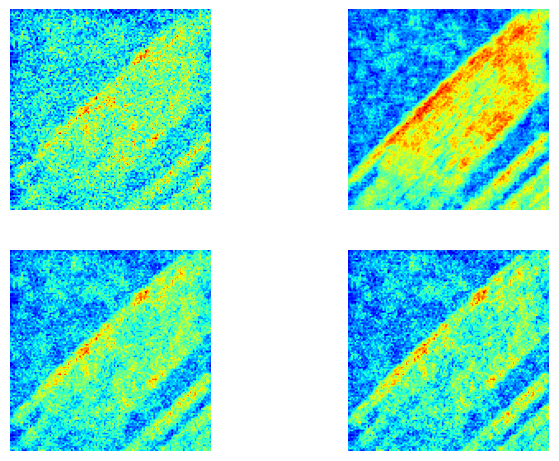

In [24]:
"""PLotting Decoded Components"""
rows,cols = 4,2
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(4): #n_comp
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(decoded[2,:,:,i], cmap = 'jet')      #window_size*theta_points
    # ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()